## Checking Avilable GPU

In [22]:
!nvidia-smi

Thu Mar 16 11:50:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.05    Driver Version: 525.85.05    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   62C    P2   124W / 350W |   3382MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing requirements

In [23]:
# pytorch libs
import torch
from torch import nn
import torchvision

# matplot libs
import matplotlib.pyplot as plt

# numpy
import numpy as np

# torch metrics
try:
  import torchmetrics
except:
  !pip3 -q install torchmetrics
import torchmetrics
from torchmetrics.classification import Accuracy,MulticlassAccuracy

try:
  import torchinfo
except:
  !pip3 -q install torchinfo
finally:
  from torchinfo import summary

try:
  import torchattacks
except:
  !pip3 -q install torchattacks
finally:
  import torchattacks

from helper_functions import *

In [24]:
torchvision.__version__,torch.__version__

('0.14.1+cu117', '1.13.1+cu117')

## device agnostic code

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Getting Dataset with pytorch

### Downloading Dataset

In [26]:
from torchvision import transforms

image_trasform = transforms.Compose(
    [
        # transforms.Grayscale(num_output_channels=1), # converting to 1 channel
        transforms.ToTensor()
    ]
)

train_dataset = torchvision.datasets.SVHN(
    root="data/", download=True, split="train", transform=image_trasform
)

test_dataset = torchvision.datasets.SVHN(
    root="data/", download=True, split="test", transform=image_trasform
)
train_dataset, test_dataset


Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


(Dataset SVHN
     Number of datapoints: 73257
     Root location: data/
     Split: train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 Dataset SVHN
     Number of datapoints: 26032
     Root location: data/
     Split: test
     StandardTransform
 Transform: Compose(
                ToTensor()
            ))

### Vis. dataset (train dataset)

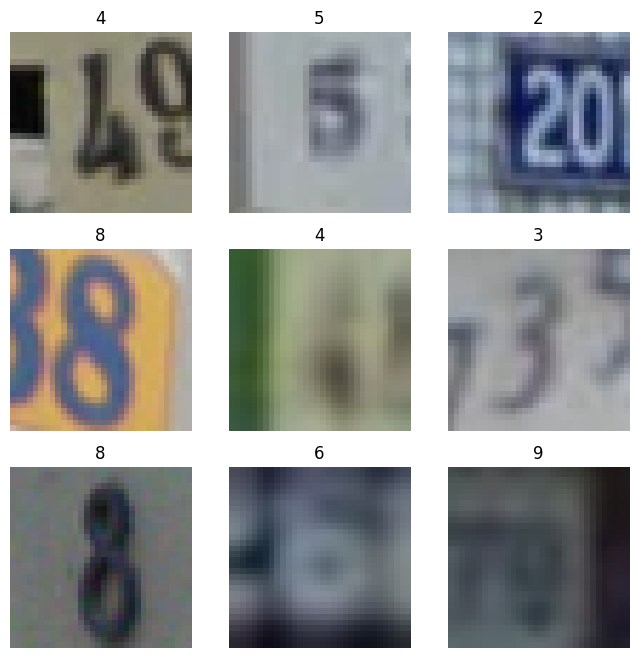

In [27]:
# randomly ploting image samples from the grayscale dataset
# labels_map = test_dataset.class_to_idx  # getting class -> index map
labels_map = {0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9"}
# labels_map = dict(map(reversed, labels_map.items()))  # inverting dict
# print(labels_map)

figure = plt.figure(figsize=(8, 8))  # fixing plotsize
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(
        len(train_dataset), size=(1,)
    )  # randomely selecting one image sample from the image index
    img, label = train_dataset[sample_idx]  # getting image and label of selected index
    # sub plot code
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(
        img.permute(1, 2, 0)
    )  # NOTE:- Color map is gray because we're converting imgae to grayscale / changing channel to HWC for color image
    # sub plot code ends
plt.show()


## Defining model

In [28]:
from torchvision.models import EfficientNet_B0_Weights, efficientnet_b0
# Model with pretrained weights Arch - EfficientNet B0
weights_effnet = EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model_effnet = efficientnet_b0(weights=weights_effnet).to(device)
auto_transforms_effnet = weights_effnet.transforms() # best available transforms
model_effnet,auto_transforms_effnet

(EfficientNet(
   (features): Sequential(
     (0): Conv2dNormActivation(
       (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): SiLU(inplace=True)
     )
     (1): Sequential(
       (0): MBConv(
         (block): Sequential(
           (0): Conv2dNormActivation(
             (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
             (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
             (2): SiLU(inplace=True)
           )
           (1): SqueezeExcitation(
             (avgpool): AdaptiveAvgPool2d(output_size=1)
             (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
             (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
             (activation): SiLU(inplace=True)
             (scale_activation): Sigmoid()
           )
          

In [29]:
from torchvision.models import resnet34, ResNet34_Weights
# Note that these weights may change across versions
# Best available weights (currently alias for IMAGENET1K_V2)
weights_resnet = ResNet34_Weights.DEFAULT
model_resnet = resnet34(weights=weights_resnet).to(device)
auto_transforms_resnet = weights_resnet.transforms() # best available transforms
model_resnet,auto_transforms_resnet

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/planck/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

In [30]:
# freeze all the layers effnet
for param in model_effnet.features.parameters():
    param.requires_grad = False
model_effnet.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=10, # same number of output units as our number of classes
                    bias=True)).to(device)

# freeze all the layers resnet
for param in model_resnet.parameters():
    param.requires_grad = False
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 10)
model_resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Model summries

In [31]:
from torchinfo import summary
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model_effnet, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [32]:
from torchinfo import summary
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model_resnet, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

### Converting dataset to dataloader

In [33]:
import os

# hyper parms. for dataloader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()  # no. of avilable cpu cores

# train dataloader
train_dataloader_effnet = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.SVHN(
        root="data/", download=True, split="train", transform=auto_transforms_effnet
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
# train dataloader
train_dataloader_resnet = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.SVHN(
        root="data/", download=True, split="train", transform=auto_transforms_resnet
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)

# test dataloader
test_dataloader_effnet = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.SVHN(
        root="data/", download=True, split="test", transform=auto_transforms_effnet
    ),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)
# test dataloader
test_dataloader_resnet = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.SVHN(
        root="data/", download=True, split="test", transform=auto_transforms_resnet
    ),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

print(f"Numbers of Batches in Train Dataloader: {len(train_dataloader_effnet)}")
print(f"Numbers of Batches in Test Dataloader: {len(test_dataloader_effnet)}")
# train_dataloader,test_dataloader


Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Numbers of Batches in Train Dataloader: 2290
Numbers of Batches in Test Dataloader: 814


## Models Training

### set seeds function

In [34]:
### set seed function
def set_seed(seed: int = 42):
    """
    sets mannual seeds for both cpu and cuda
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


### making training, testing steps, train model functions

#### train step

In [35]:
def training_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    device: str,
):
    """
    Desc:
      funtion to perform traning step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      optimizer (torch.optim.Optimizer): Optimizer Function (object) of your choice
      device (str): Torch Device "CPU/GPU"
    Returns:
      train_loss (float), train_acc (float): training loss and training accuracy for one EPOCH
    """
    model.train()  # putting model in traing model

    train_loss, train_acc = 0, 0  # initlizing loss and acc. for the epoch

    # print(type(model.parameters()))
    for (X, y) in dataloader:  # loop in batches
        # model_parms_before_forward_pass = np.array([x.detach().numpy() for x in model.parameters()].copy())
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

        # 1. forward pass
        y_pred_logits = model(X)

        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backword
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        # model_parms_after_forward_pass = np.array([x.detach().numpy() for x in model.parameters()])
        # print("Model parms diff:")
        # print([(i,j) for (i,j) in zip(iter(model_parms_after_forward_pass),iter(model_parms_before_forward_pass))])
        # print(model_parms_after_forward_pass - model_parms_before_forward_pass,sep="\n")
        train_acc += acc_fn(y_pred_logits.argmax(dim=1), y).item()

    # 6. returning actual loss and acc.x
    return train_loss / len(dataloader), train_acc / len(dataloader)


#### test step

In [36]:
def testing_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    device: str,
):
    """
    Desc:
      funtion to perform testing step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): testing dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
    Returns:
      test_loss (float), test_acc (float): testing loss and testing accuracy for one EPOCH
    """
    model.eval()  # putting model in eval model

    test_loss, test_acc = 0, 0  # initlizing loss and acc. for the epoch

    with torch.inference_mode():
        for (X, y) in dataloader:  # loop in batches
            X, y = X.to(device), y.to(device)  # sending the data to target device
            # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

            # 1. forward pass
            y_pred_logits = model(X)

            # 2. calculate the loss
            loss = loss_fn(y_pred_logits, y)
            test_loss += loss.item()

            # 3. calculating accuracy
            test_acc += acc_fn(y_pred_logits.argmax(dim=1), y).item()
            # test_acc += (y_pred_logits.argmax(dim=1) == y).sum().item()/len(y)

    # 6. returning actual loss and acc.
    return test_loss / len(dataloader), test_acc / len(dataloader)


#### training function

In [37]:
from tqdm.auto import tqdm


def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    epochs: int,
):
    """
    Desc:
      funtion to perform training for one {epochs} param

    Args:
      model (nn.Module): Pytorch model class object
      train_dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      test_dataloader (torch.utils.data.DataLoader): testing dataloder from testing dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
    Returns:
      result_dict ({str: List[float]}): testing loss and testing accuracy for one EPOCH
    """
    # 1. init. result dict
    result_dict = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # 2. loop in range epochs performs train and test steps on the model
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = training_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            optimizer=optimizer,
            device=device,
        )

        test_loss, test_acc = testing_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            device=device,
        )

        # 3. print out results
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 4. adding results to result_dict
        result_dict["train_loss"].append(train_loss)
        result_dict["train_acc"].append(train_acc)
        result_dict["test_loss"].append(test_loss)
        result_dict["test_acc"].append(test_acc)

    # 5. return result dict
    return result_dict


### train loop for model_effnet and model_resnet

In [38]:
# init. epochs
NUM_EPOCHS = 15

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = MulticlassAccuracy(num_classes=len(labels_map.keys())).to(device=device)
optimizer = torch.optim.Adam(
    params=model_effnet.parameters(), lr=0.001
)

# importing and init. the timer for checking model training time
from timeit import default_timer as timer

start_time = timer()

# train model *uncomment to train the model*
model_effnet_results = train(
    model=model_effnet,
    train_dataloader=train_dataloader_effnet,
    test_dataloader=test_dataloader_effnet,
    optimizer=optimizer,
    loss_fn=loss_fn,
    acc_fn=acc_fn,
    epochs=NUM_EPOCHS,
)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
# print("model stats:")
# print(model_0_results)


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7303 | train_acc: 0.3565 | test_loss: 1.4631 | test_acc: 0.4466
Epoch: 2 | train_loss: 1.6190 | train_acc: 0.4052 | test_loss: 1.4546 | test_acc: 0.4525
Epoch: 3 | train_loss: 1.6110 | train_acc: 0.4099 | test_loss: 1.4096 | test_acc: 0.4650
Epoch: 4 | train_loss: 1.6074 | train_acc: 0.4114 | test_loss: 1.4169 | test_acc: 0.4521
Epoch: 5 | train_loss: 1.6020 | train_acc: 0.4132 | test_loss: 1.4224 | test_acc: 0.4500
Epoch: 6 | train_loss: 1.6007 | train_acc: 0.4158 | test_loss: 1.4077 | test_acc: 0.4611
Epoch: 7 | train_loss: 1.6063 | train_acc: 0.4113 | test_loss: 1.3802 | test_acc: 0.4613
Epoch: 8 | train_loss: 1.6057 | train_acc: 0.4110 | test_loss: 1.4265 | test_acc: 0.4570
Epoch: 9 | train_loss: 1.6013 | train_acc: 0.4137 | test_loss: 1.4317 | test_acc: 0.4498
Epoch: 10 | train_loss: 1.6027 | train_acc: 0.4115 | test_loss: 1.3979 | test_acc: 0.4638
Epoch: 11 | train_loss: 1.6032 | train_acc: 0.4131 | test_loss: 1.4110 | test_acc: 0.4630
Epoch: 12 | train_l

In [33]:
# init. epochs
NUM_EPOCHS = 15

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = MulticlassAccuracy(num_classes=len(labels_map.keys())).to(device=device)
optimizer = torch.optim.Adam(
    params=model_resnet.parameters(), lr=0.001
)

# importing and init. the timer for checking model training time
from timeit import default_timer as timer

start_time = timer()

# train model *uncomment to train the model*
model_resnet_results = train(
    model=model_resnet,
    train_dataloader=train_dataloader_resnet,
    test_dataloader=test_dataloader_resnet,
    optimizer=optimizer,
    loss_fn=loss_fn,
    acc_fn=acc_fn,
    epochs=NUM_EPOCHS,
)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
# print("model stats:")
# print(model_0_results)


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8573 | train_acc: 0.2952 | test_loss: 1.7167 | test_acc: 0.3452
Epoch: 2 | train_loss: 1.7235 | train_acc: 0.3520 | test_loss: 1.6756 | test_acc: 0.3541
Epoch: 3 | train_loss: 1.6972 | train_acc: 0.3673 | test_loss: 1.6537 | test_acc: 0.3658
Epoch: 4 | train_loss: 1.6818 | train_acc: 0.3702 | test_loss: 1.6454 | test_acc: 0.3716
Epoch: 5 | train_loss: 1.6712 | train_acc: 0.3762 | test_loss: 1.6442 | test_acc: 0.3835
Epoch: 6 | train_loss: 1.6694 | train_acc: 0.3769 | test_loss: 1.6279 | test_acc: 0.3645
Epoch: 7 | train_loss: 1.6589 | train_acc: 0.3835 | test_loss: 1.6550 | test_acc: 0.3609
Epoch: 8 | train_loss: 1.6581 | train_acc: 0.3827 | test_loss: 1.6174 | test_acc: 0.3942
Epoch: 9 | train_loss: 1.6576 | train_acc: 0.3843 | test_loss: 1.6180 | test_acc: 0.3659
Epoch: 10 | train_loss: 1.6505 | train_acc: 0.3860 | test_loss: 1.6000 | test_acc: 0.3761
Epoch: 11 | train_loss: 1.6520 | train_acc: 0.3853 | test_loss: 1.6444 | test_acc: 0.3671
Epoch: 12 | train_l

## Saving the trained model

#### saving

In [56]:
from pathlib import Path

Path("models").mkdir(parents=True, exist_ok=True)

PATH = "models/"

NAME = PATH + "model_effnet_b0_15_epochs.pt"
# saving model
try:
    torch.save(model_effnet.state_dict(), NAME)
except:
    print("model not saved, check the path or saved models")

In [34]:
from pathlib import Path

Path("models").mkdir(parents=True, exist_ok=True)

PATH = "models/"

NAME = PATH + "model_resnet_34_15_epochs.pt"
# saving model
try:
    torch.save(model_resnet.state_dict(), NAME)
except:
    print("model not saved, check the path or saved models")

#### loading

In [35]:
# logging model
from pathlib import Path

Path("models").mkdir(parents=True, exist_ok=True)

PATH = "models/"

NAME = PATH + "model_effnet_b0_15_epochs.pt"
# # number of classes in dataset
# class_names = train_dataset.classes
# set_seed(seed=42)

# init. model
model_effnet = efficientnet_b0().to(device=device)
model_effnet.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=10, # same number of output units as our number of classes
                    bias=True)).to(device)

model_effnet.load_state_dict(torch.load(NAME))
model_effnet.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [16]:
# logging model
from pathlib import Path

Path("models").mkdir(parents=True, exist_ok=True)

PATH = "models/"

NAME = PATH + "model_resnet_34_15_epochs.pt"
# number of classes in dataset
# class_names = train_dataset.classes
# set_seed(seed=42)

# init. model
model_resnet = resnet34(weights=weights_resnet).to(device)
model_resnet.fc = nn.Linear(num_ftrs, 10).to(device)

model_resnet.load_state_dict(torch.load(NAME))
model_resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Testing the loaded models

In [36]:
# For EfficientNet
# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task="multiclass", num_classes=10).to(device=device)
# acc_fn = accuracy_fn

test_loss,test_acc = testing_step(
    model=model_effnet,
    dataloader=test_dataloader_effnet,
    acc_fn=acc_fn,
    loss_fn=loss_fn,
    device=device,
)
print(f"test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}") # test_loss: 1.4246 | test_acc: 0.5136

test_loss: 1.4246 | test_acc: 0.5136


In [37]:
# For ResNet
# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task="multiclass", num_classes=10).to(device=device)
# acc_fn = accuracy_fn

test_loss,test_acc = testing_step(
    model=model_resnet,
    dataloader=test_dataloader_resnet,
    acc_fn=acc_fn,
    loss_fn=loss_fn,
    device=device,
)
print(f"test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}") # test_loss: 1.6095 | test_acc: 0.4511

test_loss: 2.3172 | test_acc: 0.1530


## Impacts of attack on both models

### Defining attacks effnet PGD

In [40]:
atk = torchattacks.PGD(model_effnet, eps=8/255, alpha=2/255, steps=4)
metric = Accuracy(task="multiclass", num_classes=10).to(device=device)

acc = 0
for data, target in test_dataloader_effnet:
    data, target = data.to(device), target.to(device)
    data = atk(data, target) #purturbed data
    output = model_effnet(data)
    acc += metric(output, target).item()
print(f'Purtubed Test accuracy: {acc / len(test_dataloader_effnet):.4f}')

Purtubed Test accuracy: 0.0864%


### Defining attacks resnet PGD

In [41]:
atk = torchattacks.PGD(model_resnet, eps=8/255, alpha=2/255, steps=4)
metric = Accuracy(task="multiclass", num_classes=10).to(device=device)

acc = 0
for data, target in test_dataloader_resnet:
    data, target = data.to(device), target.to(device)
    data = atk(data, target) #purturbed data
    output = model_resnet(data)
    acc += metric(output, target).item()
print(f'Purtubed Test accuracy: {acc / len(test_dataloader_resnet):.4f}')

Purtubed Test accuracy: 0.0183%


### Defining attacks effnet Jitter

In [38]:
atk = torchattacks.Jitter(model_effnet, eps=8/255, steps=4)
metric = Accuracy(task="multiclass", num_classes=10).to(device=device)

acc = 0
for data, target in test_dataloader_effnet:
    data, target = data.to(device), target.to(device)
    data = atk(data, target) #purturbed data
    output = model_effnet(data)
    acc += metric(output, target).item()
print(f'Purtubed Test accuracy: {acc / len(test_dataloader_effnet):.4f}')

Purtubed Test accuracy: 0.0721%


### Defining attacks resnet Jitter

In [39]:
atk = torchattacks.Jitter(model_resnet, eps=8/255, steps=4)
metric = Accuracy(task="multiclass", num_classes=10).to(device=device)

acc = 0
for data, target in test_dataloader_resnet:
    data, target = data.to(device), target.to(device)
    data = atk(data, target) #purturbed data
    output = model_resnet(data)
    acc += metric(output, target).item()
print(f'Purtubed Test accuracy: {acc / len(test_dataloader_resnet):.4f}')

Purtubed Test accuracy: 0.0362%
